In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [157]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from skimage import color, data, restoration
from ksvd import ApproximateKSVD
from sklearn.linear_model import orthogonal_mp_gram

import utils
from utils.utils import gaussian_kernel, matlab_style_gauss2D as gaussian_kernel, matlab_style_gauss2D
from utils.odctdict import odctdict as odctdict

In [159]:
def get_patch_indices(image, i, j, patch_size):
    """
    @brief      Return a patch of size patch_size that is within the bounds of the image
                
    @param      image      image to extract patch
    @param      i          patch height index
    @param      j          patch width index
    @param      patch_size tuple containing desired patch dimensions
    
    @return     tuple of 4 elements: (height start, height end, width start, width end)
    """
    if i >= image.shape[0]-patch_size and j >= image.shape[1]-patch_size:
        indices = (image.shape[0]-patch_size, image.shape[0], image.shape[1]-patch_size, image.shape[1])
    elif i >= image.shape[0]-patch_size:
        indices = (image.shape[0]-patch_size, image.shape[0], j, j+patch_size)
    elif j >= image.shape[1]-patch_size:
        indices = (i, i+patch_size, image.shape[1]-patch_size, image.shape[1])
    else:
        indices = (i, i+patch_size, j, j+patch_size)
    return indices

In [210]:
def direct_sparse(img, D, kernel, num_patches, skip):
    """
    @brief      Direct sparese algoritm by Yifei Lou that solves the deblur problem with
                known kernel. This function also tries to reconstruct the image.
                
    @param      img         blurred image B
    @param      D           dictionary D shape NxM
    @param      kernel      kernel K
    @param      num_patches number of patches we are extracting from B
    @param      skip        number of pixels to skip between each patch
    
    @return     reconstructed image (B.shape), update dictionary (NxM), 
                coefficients (num_patches x M)
    """
    n, m = D.shape
    kernel_size = kernel.shape[0]
    
    patch_size = int(np.sqrt(n))
    
    I_hat = restoration.richardson_lucy(blur_img, kernel)
    
    patch_index = 0
    I_p_hat = np.zeros((num_patches, n))
    
    B = np.zeros((num_patches, n))
    
    # Get image patches
    for i in range(0, blur_img.shape[0]-patch_size+skip[0], skip[0]):
        for j in range(0, blur_img.shape[1]-patch_size+skip[1], skip[1]):
            indices = get_patch_indices(blur_img, i, j, patch_size)
            B[patch_index] = blur_img[indices[0]:indices[1], indices[2]:indices[3]].reshape(-1)
            I_p_hat[patch_index] = I_hat[indices[0]:indices[1], indices[2]:indices[3]].reshape(-1)
            patch_index += 1
            
    # update dictionary with K-SVD algorithm
    aksvd = ApproximateKSVD(n_components=m)
    D_next = aksvd.fit(I_p_hat).components_
    D_next = D_next.T
    D_hat = cv2.filter2D(D_next, -1, kernel)
    D_hat /= np.linalg.norm(D_hat.reshape(-1), 2)
    

    # Estimate sparse coefficients
    regularization = min(max(n / 10, 1), m)
    gram = D_hat.T@D_hat
    cov = D_hat.T@(B.T)
    norms_squared = np.sqrt((B * B).sum(axis=1))
    Alpha = orthogonal_mp_gram(gram, cov, n_nonzero_coefs=int(regularization), norms_squared=norms_squared)
    Alpha = Alpha.T
    
    
    s = 5
    unblur_img = np.zeros(blur_img.shape)
    weights = np.ones(blur_img.shape)*1e-10
    patch_index = 0
    
    # recover latent image
    for i in range(0, blur_img.shape[0]-patch_size+skip[0], skip[0]):
        for j in range(0, blur_img.shape[1]-patch_size+skip[1], skip[1]):
            indices = get_patch_indices(blur_img, i, j, patch_size)
            
            weight = np.exp((1 - np.linalg.norm(Alpha[patch_index].reshape(-1), 0))/s)
            unblur_img[indices[0]:indices[1], indices[2]:indices[3]] += weight*(D_hat@Alpha[patch_index]).reshape((patch_size, patch_size))
            weights[indices[0]:indices[1], indices[2]:indices[3]] += weight
            
            patch_index += 1
    
    unblur_img /= weights
    unblur_img /= np.linalg.norm(unblur_img)
    return unblur_img, D_next, Alpha
                

In [211]:
def estimate_kernel(blur_img, I, kernel_size, lambda_=5):
    """
    @brief      Estimate the blur kernel by solving with Tikhonov regularization
                
    @param      blur_img    blurred image that we are trying to deblur
    @param      I           Richardson-Lucy reconstructed image
    @param      kernel_size desired size of the kernel
    @param      lambda      Tikhonov constant
    
    @return     updated kernel of size (kernel_size, kernel_size)
    """
    # count number of patches
    im_h, im_w = blur_img.shape[0], blur_img.shape[1]
    k = kernel_size*kernel_size
    
    num_patches = 0
    for i in range(0, im_h-kernel_size):
        for j in range(0, im_w-kernel_size):
            num_patches += kernel_size
    
    # build A and B matrices
    index = 0
    A = np.zeros((num_patches, kernel_size))
    B = np.zeros((num_patches, kernel_size))
    for i in range(im_h-kernel_size):
        for j in range(im_w-kernel_size):
            A[index:index+kernel_size] = I[i:i+kernel_size, j:j+kernel_size]
            B[index:index+kernel_size] = blur_img[i:i+kernel_size, j:j+kernel_size]
            index += kernel_size
    
    # calculate x_hat, the kernel for the next iteration
    Gamma = np.identity(kernel_size)
    Tikhonov = np.matmul(A.T, A) + lambda_*np.matmul(Gamma.T, Gamma)
    kernel_next = np.matmul(np.linalg.inv(Tikhonov), np.matmul(A.T, B))
    
    # renormalize kernel
    kernel_next /= np.sum(kernel_next.reshape(-1))    
    return kernel_next

In [222]:
def deblur(blur_img, kernel_size=7, patch_size=12, iters=6, blur_strength = 0.4, skip=(3,3)):
    """
    @brief      Deblur a single image with adapative dictionary learning. Algorithm described
                by Hu et al. 2010.
                
    @param      blur_img      blurred image that we are trying to deblur
    @param      kernel_size   desired size of the kernel
    @param      patch_size    tuple containing desired patch dimensions
    @param      iters         number of iterations to do
    @param      blur_strength desired gaussian blur on the intial kernel
    @param      skip          tuple containing number of pixels to skip in between patches
    
    @return     Richardson-Lucy reconstructed image (blur_img.shape),
                final estimated kernel (kernel_size x kernel_size)
    """
    kernel = matlab_style_gauss2D((kernel_size, kernel_size), blur_strength)
        
    n = patch_size**2
    m = 10*n
    
    num_patches = 0
    for i in range(0, blur_img.shape[0]-patch_size+skip[0], skip[0]):
        for j in range(0, blur_img.shape[1]-patch_size+skip[1], skip[1]):
            num_patches += 1
    
    D = odctdict(n, m)
    I = blur_img
    
    for t in range(iters):       
        I, D, Alpha = direct_sparse(blur_img, D, kernel, num_patches, skip)
        kernel = estimate_kernel(blur_img, I, kernel_size)
        
        print('Iteration: {}'.format(t+1))
        f, axis = plt.subplots(1,2)
        deconvoluted = restoration.richardson_lucy(blur_img, kernel)
        axis[0].imshow(I*255., cmap='gray')
        axis[0].set_title('reconstructed')
        axis[1].imshow(deconvoluted, cmap='gray')
        axis[1].set_title('deconvoluted')
        plt.show()
        
    return I, kernel
    

Original: 


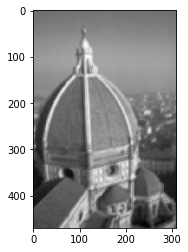

Iteration: 1


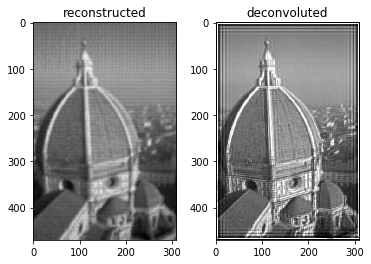

Iteration: 2


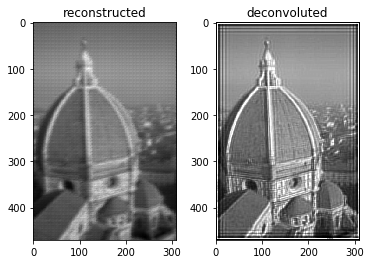

Iteration: 3


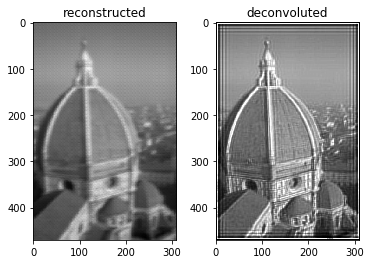

Iteration: 4


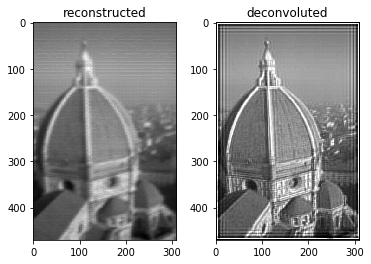

Iteration: 5


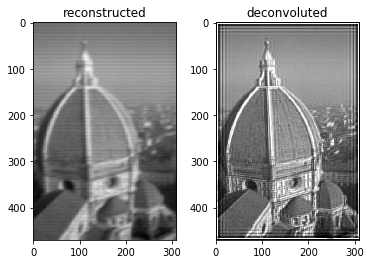

Iteration: 6


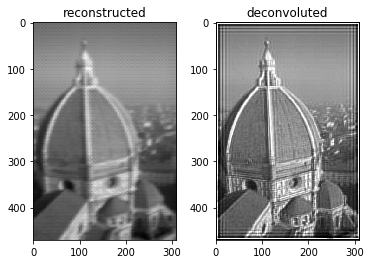

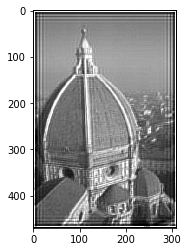

True

In [223]:
blur_img_name = 'blurred'
blur_img_path = 'data/' + blur_img_name
blur_img = cv2.cvtColor(cv2.imread(blur_img_path + '.jpg'), cv2.COLOR_BGRA2GRAY).astype('double') / 255.0

print('Original: ')
plt.imshow(blur_img, cmap='gray')
plt.show()

kernel_size   = 7
patch_size    = 7
iters         = 10
blur_strength = 0.4
skip          = (3,3)

deblur_img, kernel = deblur(blur_img, kernel_size=kernel_size, patch_size=patch_size, skip=skip)

output_img = restoration.richardson_lucy(blur_img, kernel)
plt.imshow(output_img, cmap='gray')
plt.show()

deblur_img_path = 'output/' + blur_img_name
cv2.imwrite(deblur_img_path + '.jpg', output_img*255.)
